## Solving the TOV equations
The TOV equations are:

$\frac{\mathrm{d} m}{\mathrm{d} r} = 4\pi r^2 \rho$

$\frac{\mathrm{d} P}{\mathrm{d} r} = -\frac{\rho m  }{r^2}\big(1+\frac{P}{\rho} \big)\big(1+\frac{4\pi P r^3}{m}\big)  \big(1-\frac{2 m}{r}\big)^{-1}.$

Here $r$ is the radial coordinate. $P$, $m$, and $\rho$ are radial profiles of the pressure, total enclosed massed and total density, respectively. Keep in mind that $\rho$ is not the rest mass density, but rather the total mass-energy density. The rest-mass density $\rho_0$ is related to $\rho$ in the following way

$\rho = \rho_0 (1 + \epsilon),$

where $\epsilon$ is the internal energy density per unit rest mass. 



So far we do not provide enough equations to solve the problem at hand, we have two equations and three unknowns. To close the system we need to specify a relationship between the pressure and density, an equation of state.

In this code, we will use a piecewise-polytropic equation of state which is defined as

$P = \begin{cases}
 & K_1 \ \rho^{\Gamma_1} \ \text{ if } \ \rho < \rho_t \\ 
 & K_2 \ \rho^{\Gamma_2} \ \text{ if } \ \rho > \rho_t 
\end{cases},$

where $\rho_t$ is some density threshold at which the
equation of state switches between the different states.

The system of equations can be solved by specifying initial values at $r = 0$ and integrating outwards until the pressure drops below zero, which defines the surface of our star.

In the code, we use the following notation

$ \rho = ro, \quad P = P, \quad \epsilon = e, \quad m = m, \quad r = r, \quad \Gamma_1 = L1, \quad \Gamma_2 = L2, \quad K_1 = K1, \quad K_2 = K2, \quad \rho_t = \text{rhot} $

In [1]:
#Simply load some necessary python libs
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator

In [2]:
#Set plot parameters, this is not strictly needed. However,
#it will make our plots look nicer.
#If the plots look strange, change to fit your screen and machine.
matplotlib.rcParams['axes.linewidth'] = 4
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 4
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['xtick.minor.width'] = 3

matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 4
matplotlib.rcParams['ytick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.width'] = 3

matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True

The next four cells define the functions that we need to solve our problem. Take note of the fact that we need to define two equation of state functions. The reason for this has to do with how the numerical scheme works, at certain steps in the routine we will need to know the density as a function of pressure and at others we know the density and need the pressure.

In [3]:
#Defines the internal energy density per unit rest mass
def eps(rho,K1,K2,L1,L2,rhot):
    if(rho < rhot):
        return K1*(rho**(L1-1))/(L1-1)
    else:
        deps = K1*(rhot**(L1-1))/(L1-1) - K2*(rhot**(L2-1))/(L2-1)
        return K2*(rho**(L2-1))/(L2-1) + deps
    return 0

In [4]:
#Equation of state, pressure as a function of density
def eos_P(rho,K1,K2,L1,L2,rhot):
    if(rho < rhot):
        return K1*rho**L1
    else:
        return K2*rho**L2
    return 0

In [5]:
#Equation of state, density as a function of pressure
def eos_rho(P,K1,K2,L1,L2,rhot,m):
    if(P < eos_P(rhot,K1,K2,L1,L2,rhot)):
        return (P/K1)**(1/L1)
    else:
        return (P/K2)**(1/L2)
    return 0

In [6]:
#First TOV equation, dP/dr
def dpdr(P,rho,m,r,K1,K2,L1,L2,rhot):
    e = eps(rho,K1,K2,L1,L2,rhot)
    ro = rho*(1+e)
    if( r != 0 ):
        return -(ro/(r**2)*(1+P/ro)*(m+4*np.pi*P*r**3)/(1-2*m/r))
    else:
        return 0
    return a

In [7]:
#Second TOV equation dm/dr
def dmdr(rho,r,K1,K2,L1,L2,rhot):
    e = eps(rho,K1,K2,L1,L2,rhot)
    ro = rho*(1+e)
    return 4*np.pi*r**2*ro

In the next cell we define the Runge-Kutta solver. 
Given an initial value problem

$\frac{\mathrm{d} y}{\mathrm{d} r} = f(y,r), \quad y(0) = y_0$

we can discretise and solve the problem using the famous Runge-Kutta method.

Given a step size $h$ we have

$y_{n+1} = y_n + \frac{1}{6} \big( C_1 + 2(C_2 + C_3) + C_4 \big) \\ r_{n+1} = r_n + h$.

With

$C_1 = h \ f(y_0,r_0) \\ C_2 = h \ f(y_0 + h/2 ,r_0+C_1/2) \\ C_3 = h \ f(y_0 + h/2 ,r_0+C_2/2) \\
C_4 = h \  f(y_0 + h ,r_0+C_3)$.

Since we know $y_0 ( = y(0)) $, we can calculate $y_1$ and so on using this method. 
Our system consists of more than one equation, so we have to perform the Runke-Kutta steps for all the functions simultaneously.


https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#The_Runge%E2%80%93Kutta_method

The function we define below returns arrays containing the radius, total mass-energy density, the total mass and the pressure. The user has to specify the equation of state to use, by setting K1, L1, L2, dr and rhot. 

In [32]:
def RGK4(rhoc,K1,L1,L2,rhot,dr):
    #First, we convert the quantities from CGS unites into dimensionless units
    rhoc = rhoc/6.1789e17
    rho = rhoc
    rhot = rhot/6.1789e17
    K1 = K1*(6.1789e17)**L1 / (5.553e38)
    K2 = K1*rhot**(L1-L2)
    P = eos_P(rhoc,K1,K2,L1,L2,rhot)
    dr = dr/1.48e5
    
    r = 0
    m = 0
    cm = np.ones(4)
    cp = np.ones(4)
    
    pa = []
    ma = []
    ra = []
    da = []
    while(P > (1e-8)):
        cm[0] = dr*dmdr(rho,r,K1,K2,L1,L2,rhot)
        cp[0] = dr*dpdr(P,rho,m,r,K1,K2,L1,L2,rhot)

        rho = eos_rho(P+cp[0]/2,K1,K2,L1,L2,rhot,m+cm[0]/2)
        cm[1] = dr*dmdr(rho,r+dr/2,K1,K2,L1,L2,rhot)
        cp[1] = dr*dpdr(P+cp[0]/2,rho,m+cm[0]/2,r+dr/2,K1,K2,L1,L2,rhot)

        rho = eos_rho(P+cp[1]/2,K1,K2,L1,L2,rhot,m+cm[1]/2)
        cm[2] = dr*dmdr(rho,r+dr/2,K1,K2,L1,L2,rhot)
        cp[2] = dr*dpdr(P+cp[1]/2,rho,m+cm[1]/2,r+dr/2,K1,K2,L1,L2,rhot)

        rho = eos_rho(P+cp[2],K1,K2,L1,L2,rhot,m+cm[2])
        cm[3] = dr*dmdr(rho,r+dr,K1,K2,L1,L2,rhot)
        cp[3] = dr*dpdr(P+cp[2],rho,m+cm[2],r+dr,K1,K2,L1,L2,rhot)

        P = P+ 1/6 * (cp[0] + 2*(cp[1]+cp[2]) + cp[3])
        m = m+ 1/6 * (cm[0] + 2*(cm[1]+cm[2]) + cm[3])
        r = r + dr
        
        pa.append(P)
        ma.append(m)
        ra.append(r)
        da.append(eos_rho(P,K1,K2,L1,L2,rhot,m))
    print("Surface values")
    print("Mass: %s Msun  Radius: %s km " % ( m*6.1798e17 * (1.48e5)**3/1.989e33,r*1.48e5* 1e-5))
    return [np.array(pa)*5.553e38,np.array(ma) *6.1798e17 *(1.48e5)**3 /1.989e33 ,np.array(ra)*1.48e5,np.array(da)*6.1798e17]


# Example

In [33]:
P,m,r,den = RGK4(1500910574626378.2 ,35932607339452.99,1.35692395,3.0,93114240177596.48,14.8)

Surface values
Mass: 2.5337727633545586 Msun  Radius: 11.55169599999282 km 


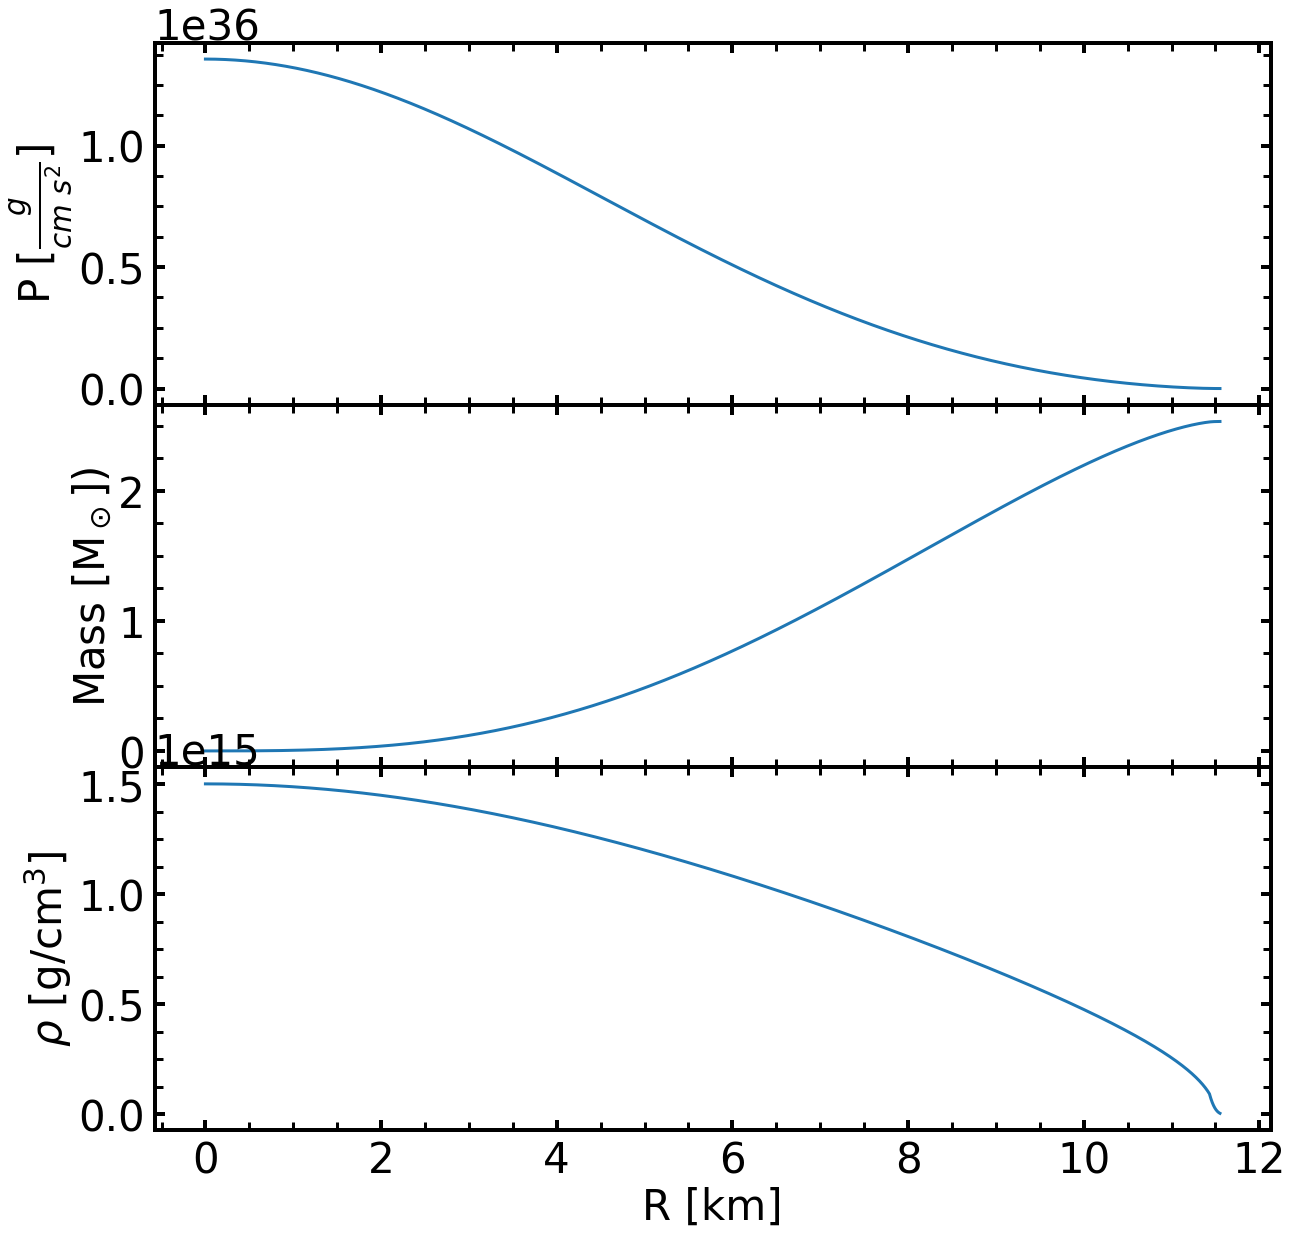

In [27]:
f,ax = plt.subplots(figsize=(20,20),ncols=1,nrows=3,sharex='all')
plt.rcParams.update({'font.size':42})
plt.subplots_adjust(hspace=0.0,wspace=.2)
ax[0].plot(r*1e-5,P,lw=3)
ax[0].set_ylabel(r'P $[ \frac{g}{cm \ s^2}]$')
ax[1].plot(r*1e-5,m,lw=3)
ax[1].set_ylabel(r'Mass [M$_\odot$])')
ax[2].plot(r*1e-5,den,lw=3)
ax[2].set_ylabel(r'$\rho$ [g/cm$^3$]')
ax[2].set_xlabel("R [km]")
for x in ax:
    x.tick_params(axis='x', pad=10)
    x.tick_params(axis='y', pad=10)
    x.xaxis.set_minor_locator(AutoMinorLocator(4))
    x.yaxis.set_minor_locator(AutoMinorLocator(4))
plt.show()

# Excercise 1)

To study how the radius and total mass of a Neutron star depend on the central density, we will now change the central density parameter in increments from $1 \times 10^{14} \text{g}\text{cm}^{3}$ to $2 \times 10^{15} \text{g}\text{cm}^{3}$. Plot the mass and radius of the star as a function of central pressure and identify the central density that results in a Neutron star mass of 1.35 $\text{M}_{\odot}$. What is the radius of this star? 

In [34]:
denc = np.linspace(1e14,2e15,20) #This will sample the central density in 20 steps
Mmax = []
Rmax = []
#Now we do a simple loop to perform the RG4 for each value in denc
for x in denc:
    P,m,r,den = RGK4(x,35932607339452.99,1.35692395,3.0,93114240177596.48,14.8)
    Mmax.append(m[-1])
    Rmax.append(r[-1])
Rmax = np.array(Rmax)
Mmax = np.array(Mmax)


Surface values
Mass: 0.07064965649272202 Msun  Radius: 11.848583999992128 km 
Surface values
Mass: 0.23092399220523802 Msun  Radius: 11.16112399999373 km 
Surface values
Mass: 0.5440116401713715 Msun  Radius: 12.18676399999134 km 
Surface values
Mass: 0.9295699718798484 Msun  Radius: 12.949259999989563 km 
Surface values
Mass: 1.3182289229767303 Msun  Radius: 13.367211999988589 km 
Surface values
Mass: 1.6631878655191197 Msun  Radius: 13.51757999998824 km 
Surface values
Mass: 1.943566038696829 Msun  Radius: 13.483687999988318 km 
Surface values
Mass: 2.1570504567118083 Msun  Radius: 13.33272799998867 km 
Surface values
Mass: 2.31103017168339 Msun  Radius: 13.112503999989183 km 
Surface values
Mass: 2.416300756927763 Msun  Radius: 12.85616799998978 km 
Surface values
Mass: 2.483641141998816 Msun  Radius: 12.585031999990413 km 
Surface values
Mass: 2.522379188661185 Msun  Radius: 12.312563999991047 km 
Surface values
Mass: 2.540027418843292 Msun  Radius: 12.047051999991664 km 
Surface v

In [47]:
#In this cell write the code needed to plot the mass and radius as functions of the central density
f,ax = plt.subplots(figsize=(20,20),ncols=1,nrows=2,sharex='all')
plt.rcParams.update({'font.size':42})
plt.subplots_adjust(hspace=0.0,wspace=.2)
ax[0].plot( , ,lw=3) #Change this line
ax[0].set_ylabel(r'P $[ \frac{g}{cm \ s^2}]$')

ax[1].plot(, ,lw=3) # Change this line

ax[1].set_ylabel(r'Mass [M$_\odot$])') 
ax[1].set_xlabel(r'$\rho_c [g/cm$^3$] ')
for x in ax:
    x.tick_params(axis='x', pad=10)
    x.tick_params(axis='y', pad=10)
    x.xaxis.set_minor_locator(AutoMinorLocator(4))
    x.yaxis.set_minor_locator(AutoMinorLocator(4))
plt.show()

SyntaxError: invalid syntax (<ipython-input-47-d1c29e2d510a>, line 5)

# Excercise 2)
Change the equation of state parameters to 

(K1, L1, L2, rhot) = (35932607339452.99,1.35692395, 3.0, 123236403316114.62) 

and repeat exercise 1. Then change the parameters to 

(K1 ,L1, L2, rhot) = (35932607339452.99, 1.35692395,3.0, 163102991267329.12) 

and repeat excercise. What happens?

Copy the code from the cells of exercise 1 and make changes where needed.


# Excercise 3)
Change the equation of state code to account for a three-layered Neutron star. The best way of doing this is to either make a copy of this notebook or to copy the relevant code to cells below this one, in that way you do not have to make changes to the original code. Having the original code unaltered is convenient for debugging.

Use the following equation of state paramaters 

K1, L1, L2, L3, rhot1, rhot2 = (35932607339452.99,1.35692395,2.752,2.8,96608832613233.62 1000326533804962.8)